# ===============================

# Mean Reversion Analysis for KELP

# ===============================


In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import os

# Display settings
sns.set(style='whitegrid')
plt.rcParams["figure.figsize"] = (14, 6)

In [2]:
# -------------------------------
# 1. Load and Combine Data
# -------------------------------

# Path to the CSV files (update this if needed)
files = [
    "data/prices_round_1_day_-2.csv",
    "data/prices_round_2_day_-1.csv",
    "data/prices_round_3_day_0.csv",
    "data/prices_round_3_day_1.csv",
    "data/prices_round_3_day_2.csv"
]

# Load all into one DataFrame
df_list = []
for file in files:
    df = pd.read_csv(file, sep=';')
    df_list.append(df)

data = pd.concat(df_list, ignore_index=True)

In [3]:
# -------------------------------
# 1. Load and Combine Data (with continuous timestamps)
# -------------------------------

# Path to the CSV files
files = [
    "data/prices_round_1_day_-2.csv",
    "data/prices_round_2_day_-1.csv",
    "data/prices_round_3_day_0.csv",
    "data/prices_round_3_day_1.csv",
    "data/prices_round_3_day_2.csv"
]

df_list = []
timestamp_offset = 0

for file in files:
    df = pd.read_csv(file, sep=';')
    df['timestamp'] += timestamp_offset
    timestamp_offset = df['timestamp'].max() + 1  # Offset for next file
    df_list.append(df)

data = pd.concat(df_list, ignore_index=True)

In [4]:
# -------------------------------
# 2. Filter for KELP only
# -------------------------------

kelp_data = data[data['product'] == 'KELP'].copy()
kelp_data.sort_values(by=['day', 'timestamp'], inplace=True)
kelp_data.reset_index(drop=True, inplace=True)

# Create a synthetic datetime index for plotting
kelp_data['time_index'] = kelp_data['day'] * 10000 + kelp_data['timestamp']

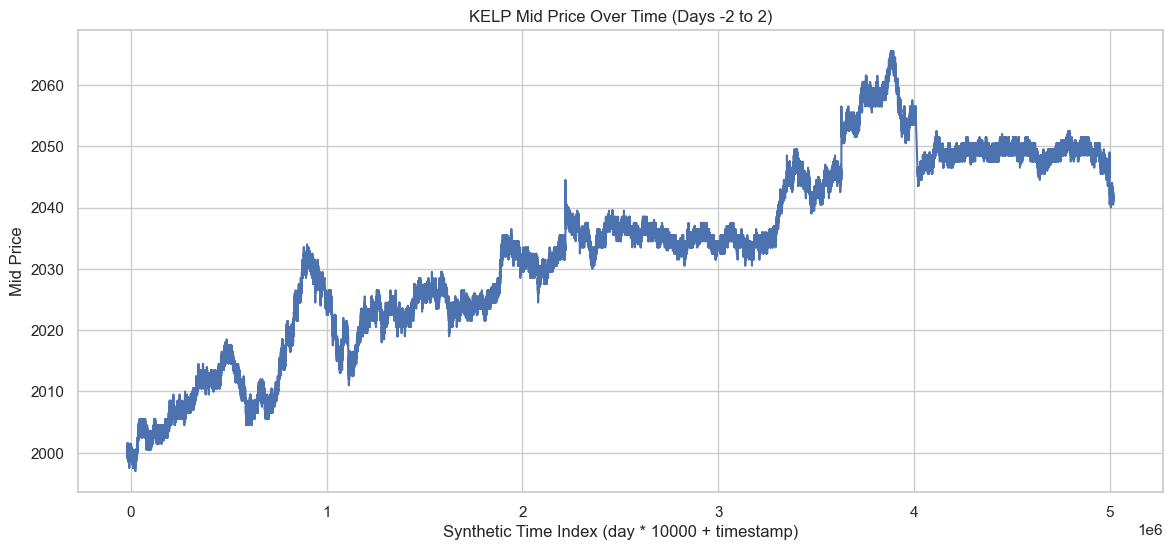

In [5]:
# -------------------------------
# 3. Plot Mid Prices
# -------------------------------

plt.plot(kelp_data['time_index'], kelp_data['mid_price'])
plt.title("KELP Mid Price Over Time (Days -2 to 2)")
plt.xlabel("Synthetic Time Index (day * 10000 + timestamp)")
plt.ylabel("Mid Price")
plt.show()

In [6]:
data[(data['day'] == -2) & (data['timestamp'] == data[data['day'] == -2]['timestamp'].max())]

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
29997,-2,999900,RAINFOREST_RESIN,9996.0,2.0,9995.0,30.0,NaN,NaN,10004,2,10005.0,30.0,NaN,NaN,10000.0,0.0
29998,-2,999900,KELP,2027.0,4.0,2026.0,32.0,NaN,NaN,2029,32,NaN,NaN,NaN,NaN,2028.0,0.0
29999,-2,999900,SQUID_INK,2003.0,4.0,2002.0,32.0,NaN,NaN,2005,32,NaN,NaN,NaN,NaN,2004.0,0.0


In [7]:
# -------------------------------
# 4. ADF Test for Stationarity
# -------------------------------

result = adfuller(kelp_data['mid_price'].dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")
    
if result[1] < 0.05:
    print("\n✅ The time series is likely stationary (good for mean reversion).")
else:
    print("\n⚠️ The time series is likely non-stationary (may not be suitable for mean reversion).")

ADF Statistic: -2.1008811347452907
p-value: 0.24416044043709545
Critical Value (1%): -3.43048090791992
Critical Value (5%): -2.8615978586109905
Critical Value (10%): -2.5668007962252677

⚠️ The time series is likely non-stationary (may not be suitable for mean reversion).


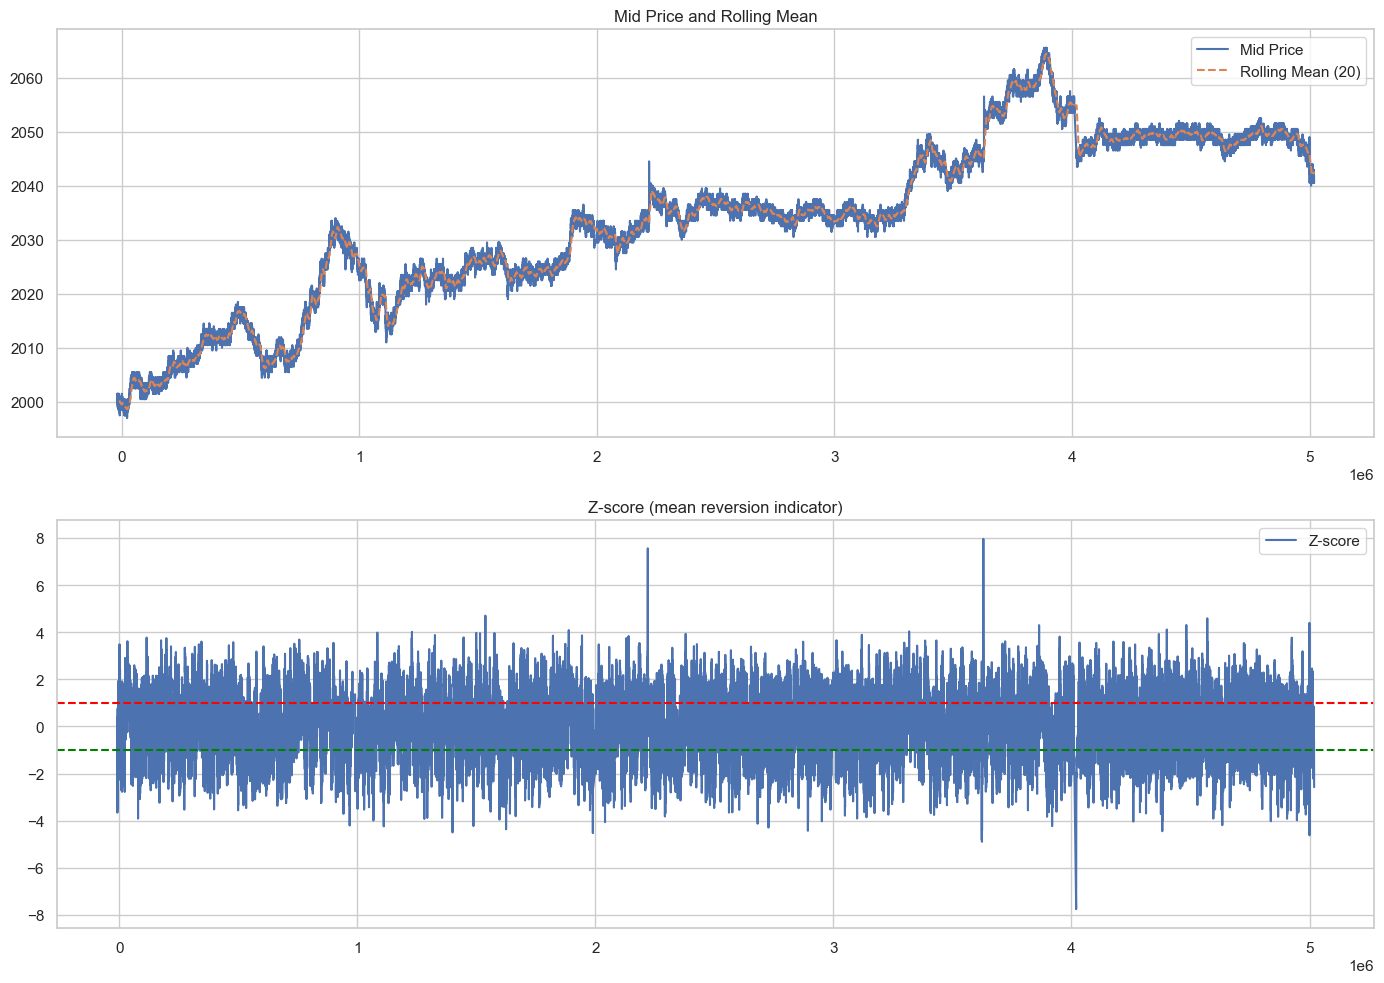

In [8]:
# -------------------------------
# 5. Visual: Rolling Mean + Z-Score
# -------------------------------

kelp_data['rolling_mean'] = kelp_data['mid_price'].rolling(window=100).mean()
kelp_data['rolling_std'] = kelp_data['mid_price'].rolling(window=100).std()
kelp_data['z_score'] = (kelp_data['mid_price'] - kelp_data['rolling_mean']) / kelp_data['rolling_std']

fig, axs = plt.subplots(2, 1, figsize=(14, 10))

# Price with rolling mean
axs[0].plot(kelp_data['time_index'], kelp_data['mid_price'], label='Mid Price')
axs[0].plot(kelp_data['time_index'], kelp_data['rolling_mean'], label='Rolling Mean (20)', linestyle='--')
axs[0].set_title('Mid Price and Rolling Mean')
axs[0].legend()

# Z-score
axs[1].plot(kelp_data['time_index'], kelp_data['z_score'], label='Z-score')
axs[1].axhline(1.0, color='red', linestyle='--')
axs[1].axhline(-1.0, color='green', linestyle='--')
axs[1].set_title('Z-score (mean reversion indicator)')
axs[1].legend()

plt.tight_layout()
plt.show()

ADF Test Analysis
• ADF Statistic: -2.10
• p-value: 0.244
• Conclusion: You fail to reject the null hypothesis of a unit root (i.e. non-stationarity).
• This indicates the KELP mid-price series does not naturally revert to a long-term mean, which is a red flag for pure mean-reversion strategies.

⸻

📉 Z-Score & Price Chart Analysis
• The rolling z-score is extremely noisy and doesn’t show many clear reversals that would typically make a mean-reverting strategy profitable.
• The mid-price trend appears to be drifting upward over time (visible in the top plot), another sign that trend or momentum may be more dominant than mean reversion.

⸻

🧠 Interpretation & Recommendations

❌ Don’t proceed with a naive mean reversion strategy:
• Entering long when price is below the mean and short above it will likely lose money due to non-stationary behavior and trending.
• The ADF test confirms the lack of mean reversion, and the visual confirms an upward drift.

⸻

✅ What to try instead:

1. Stationarize the series
   • Apply first differences: price.diff() and re-run the ADF test. You may get stationarity on returns, not prices.
   • Then consider mean reversion on z-score of returns if you want short-term reversal strategies.

2. Explore Trend Following / Momentum Strategy
   • Since the price trends, momentum strategies may perform better.
   • You can try:
   • Moving average crossover strategies.
   • Price breakout strategies.
   • Trend confirmation using MACD, RSI, etc.

3. Mean Reversion on Deviation from Trend
   • Use a detrended price, e.g. subtract a slow moving average (mid_price - SMA(100)), and test mean reversion on this residual.
   • This helps isolate short-term deviations from long-term trend


In [9]:
# First differencing to test stationarity of returns
kelp_data['returns'] = kelp_data['mid_price'].diff()
result_diff = adfuller(kelp_data['returns'].dropna())

print("ADF Statistic (Returns):", result_diff[0])
print("p-value:", result_diff[1])

ADF Statistic (Returns): -40.21626196941449
p-value: 0.0


In [10]:
# Mean reversion of detrended price
kelp_data['trend'] = kelp_data['mid_price'].rolling(window=100).mean()
kelp_data['residual'] = kelp_data['mid_price'] - kelp_data['trend']
result_residual = adfuller(kelp_data['residual'].dropna())

🧠 Strategy Idea: Detrended Z-Score Reversion

We’ll: 1. Compute a slow moving average to estimate the trend. 2. Subtract that trend from the mid-price → this gives us a “residual” (how far current price is from trend). 3. Compute z-score of the residual and use that for entry/exit signals:
• Go long when residual is low (z < -1.5)
• Go short when residual is high (z > 1.5)
• Exit when z-score crosses back toward 0.


/var/folders/s8/c86_vmt5617237s9c3g4h75r0000gn/T/ipykernel_67004/2038155609.py:23: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  kelp_data['position'] = kelp_data['signal'].replace(to_replace=0, method='ffill').fillna(0)


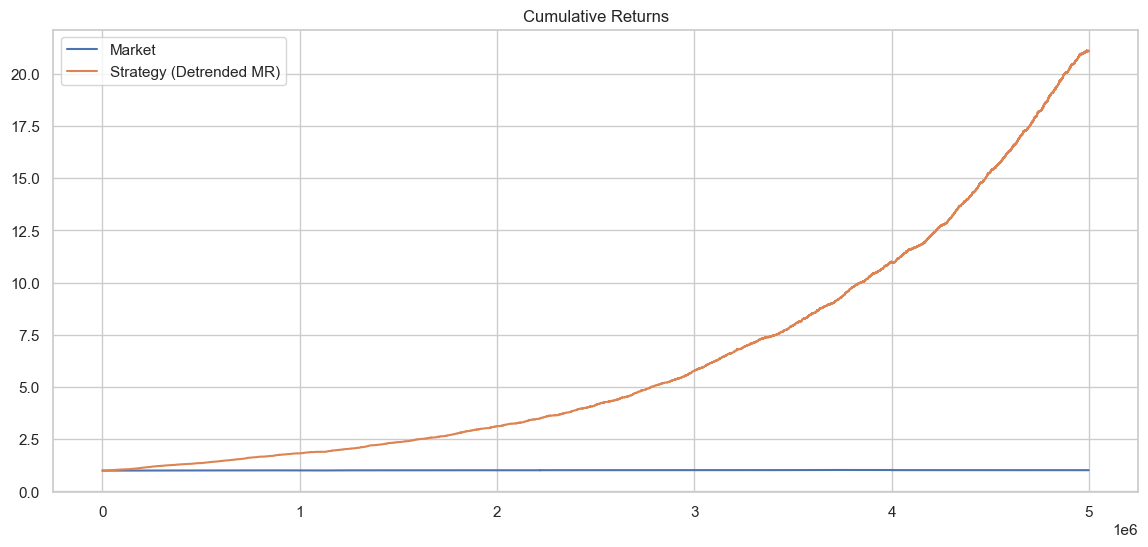

In [11]:
# ---------------------------------------
# Detrended Mean Reversion Strategy Setup
# ---------------------------------------

# 1. Estimate trend
kelp_data['trend'] = kelp_data['mid_price'].rolling(window=100).mean()

# 2. Detrend mid price
kelp_data['residual'] = kelp_data['mid_price'] - kelp_data['trend']

# 3. Compute z-score of residual
kelp_data['residual_mean'] = kelp_data['residual'].rolling(window=20).mean()
kelp_data['residual_std'] = kelp_data['residual'].rolling(window=20).std()
kelp_data['residual_z'] = (kelp_data['residual'] - kelp_data['residual_mean']) / kelp_data['residual_std']

# 4. Generate signals
kelp_data['signal'] = 0
kelp_data.loc[kelp_data['residual_z'] > 1.5, 'signal'] = -1  # short
kelp_data.loc[kelp_data['residual_z'] < -1.5, 'signal'] = 1  # long
kelp_data.loc[kelp_data['residual_z'].between(-0.5, 0.5), 'signal'] = 0  # neutral

# 5. Forward-fill signals to simulate holding position
kelp_data['position'] = kelp_data['signal'].replace(to_replace=0, method='ffill').fillna(0)

# 6. PnL estimate using simple returns
kelp_data['returns'] = kelp_data['mid_price'].pct_change()
kelp_data['strategy_returns'] = kelp_data['position'].shift(1) * kelp_data['returns']

# 7. Cumulative return plot
kelp_data['cumulative_market'] = (1 + kelp_data['returns']).cumprod()
kelp_data['cumulative_strategy'] = (1 + kelp_data['strategy_returns']).cumprod()

plt.figure(figsize=(14,6))
plt.plot(kelp_data['timestamp'], kelp_data['cumulative_market'], label='Market')
plt.plot(kelp_data['timestamp'], kelp_data['cumulative_strategy'], label='Strategy (Detrended MR)')
plt.title('Cumulative Returns')
plt.legend()
plt.show()

/var/folders/s8/c86_vmt5617237s9c3g4h75r0000gn/T/ipykernel_67004/1106935103.py:27: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)


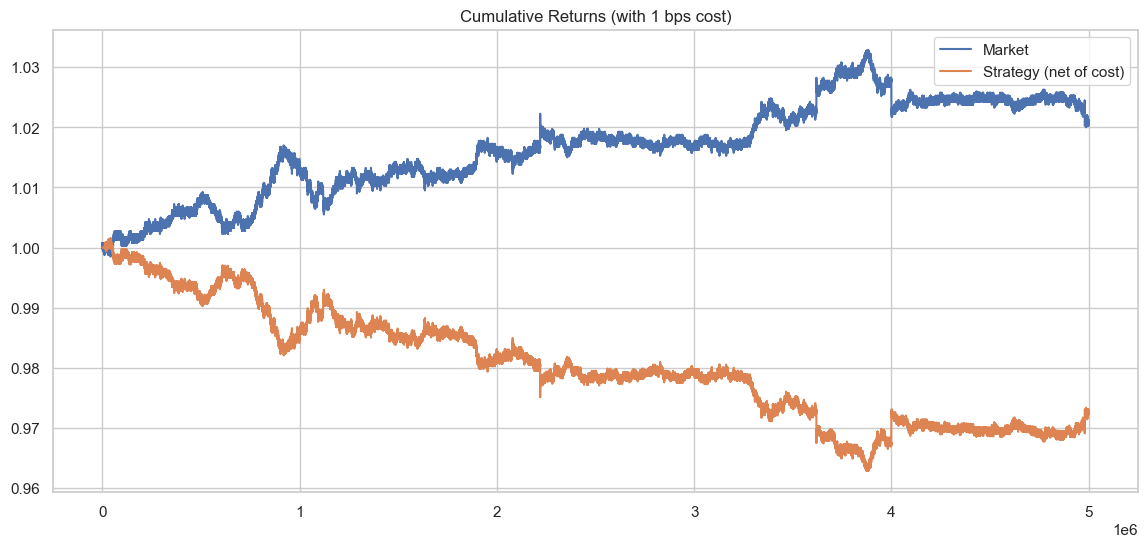

In [45]:
# ---------------------------------------
# Enhanced Strategy: Detrended MR + Costs
# ---------------------------------------

import numpy as np

# 1. Signal generation with variable z-score threshold
def run_strategy(z_entry=1.5, z_exit=0.5, cost_bps=1):
    df = kelp_data.copy()

    # Generate signal
    df['signal'] = 0
    
    # df.loc[df['residual_z'] > z_entry, 'signal'] = -1
    # df.loc[df['residual_z'] < -z_entry, 'signal'] = 1
    # df.loc[df['residual_z'].between(-z_exit, z_exit), 'signal'] = 0
    
    # Long signal: enter when z is low, exit when it gets back up
    df.loc[df['residual_z'] < -z_entry, 'signal'] = 1      # long
    df.loc[df['residual_z'] > -z_exit, 'signal'] = 0       # exit long

    # Short signal: enter when z is high, exit when it gets back down
    df.loc[df['residual_z'] > z_entry, 'signal'] = -1      # short
    df.loc[df['residual_z'] < z_exit, 'signal'] = 0        # exit short

    # Forward fill signal to build position
    df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)

    # Compute returns
    df['returns'] = df['mid_price'].pct_change()
    df['strategy_returns'] = df['position'].shift(1) * df['returns']

    # Transaction costs
    df['position_change'] = df['position'].diff().abs()
    cost_per_trade = cost_bps / 10000
    df['strategy_returns_net'] = df['strategy_returns'] - df['position_change'] * cost_per_trade

    # Cumulative
    df['cum_market'] = (1 + df['returns']).cumprod()
    df['cum_strategy_net'] = (1 + df['strategy_returns_net']).cumprod()

    return df

# ---------------------------------------
# Run and Visualize Strategy with Costs
# ---------------------------------------

result_df = run_strategy(z_entry=1.5, z_exit=0.5, cost_bps=1)

plt.figure(figsize=(14,6))
plt.plot(result_df['timestamp'], result_df['cum_market'], label='Market')
plt.plot(result_df['timestamp'], result_df['cum_strategy_net'], label='Strategy (net of cost)')
plt.title('Cumulative Returns (with 1 bps cost)')
plt.legend()
plt.show()

/var/folders/s8/c86_vmt5617237s9c3g4h75r0000gn/T/ipykernel_67004/1106935103.py:27: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
/var/folders/s8/c86_vmt5617237s9c3g4h75r0000gn/T/ipykernel_67004/1106935103.py:27: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
/var/folders/s8/c86_vmt5617237s9c3g4h75r0000gn/T/ipykernel_67004/1106935103.py:27: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
/var/folders/s8/c86_vmt5617237s9c3g4h75r0000gn/T/ipykernel_67004/1106935103.py:27: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future v

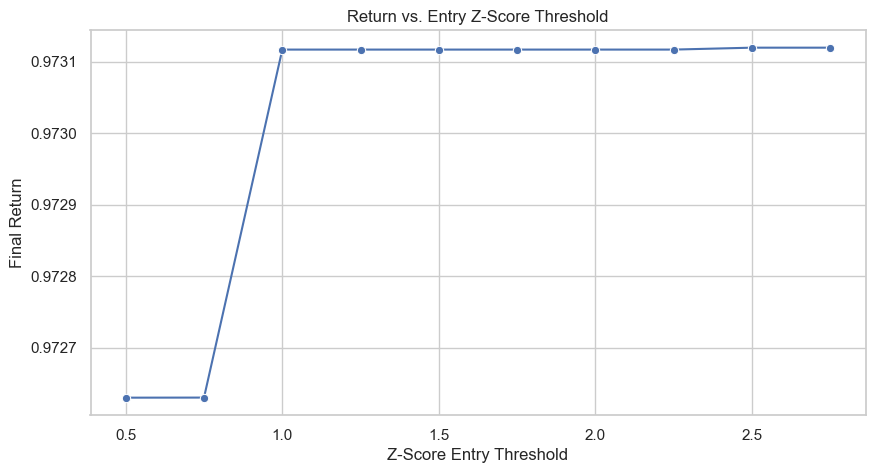

In [47]:
# ---------------------------------------
# Threshold Optimization
# ---------------------------------------

results = []

for z in np.arange(0.5, 3.0, 0.25):
    df_tmp = run_strategy(z_entry=z, z_exit=0.5, cost_bps=1)
    final_return = df_tmp['cum_strategy_net'].iloc[-1]
    results.append((z, final_return))

# Display results
opt_df = pd.DataFrame(results, columns=['z_entry_threshold', 'final_cumulative_return'])

plt.figure(figsize=(10,5))
sns.lineplot(data=opt_df, x='z_entry_threshold', y='final_cumulative_return', marker='o')
plt.title('Return vs. Entry Z-Score Threshold')
plt.xlabel('Z-Score Entry Threshold')
plt.ylabel('Final Return')
plt.grid(True)
plt.show()

In [48]:
# ---------------------------------------
# Extract Buy/Sell Timestamps
# ---------------------------------------

# Run the strategy again to ensure signals are aligned
df_trades = run_strategy(z_entry=1.0, z_exit=0.5, cost_bps=1)  # adjust threshold as needed

# Identify trade entries (when position changes)
df_trades['trade'] = df_trades['position'].diff()

# Filter only entry trades (ignoring exits to neutral)
entries = df_trades[df_trades['trade'].isin([1, -1])].copy()

# Assign trade type
entries['trade_type'] = entries['trade'].apply(lambda x: 'BUY' if x == 1 else 'SELL')

# Select useful columns
trades_df = entries[['timestamp', 'mid_price', 'residual_z', 'trade_type']].rename(columns={
    'mid_price': 'price',
    'residual_z': 'z_score'
})

# Reset index and display
trades_df.reset_index(drop=True, inplace=True)

# Show the first few trades
print("First few trades:")
display(trades_df.head(10))

# Optionally, export to CSV
trades_df.to_csv("kelp_trade_timestamps.csv", index=False)

First few trades:


/var/folders/s8/c86_vmt5617237s9c3g4h75r0000gn/T/ipykernel_67004/1106935103.py:27: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)


,timestamp,price,z_score,trade_type
0,12900,2000.5,2.252158,SELL


In [49]:
print(trades_df['trade_type'].value_counts())

trade_type
SELL    1
Name: count, dtype: int64


Z-score min: -4.230923254867493
Z-score max: 4.2160447767772125


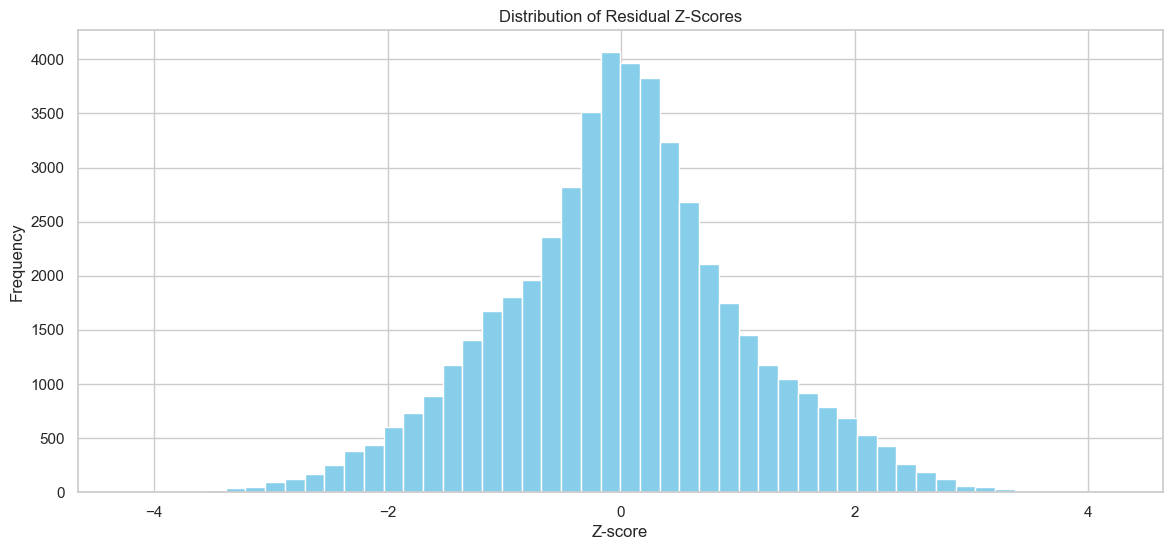

In [50]:
# Check range and distribution of z-scores
print("Z-score min:", kelp_data['residual_z'].min())
print("Z-score max:", kelp_data['residual_z'].max())

plt.hist(kelp_data['residual_z'].dropna(), bins=50, color='skyblue')
plt.title("Distribution of Residual Z-Scores")
plt.xlabel("Z-score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [51]:
trades_df = run_strategy(z_entry=0.1, z_exit=0.25, cost_bps=1)

/var/folders/s8/c86_vmt5617237s9c3g4h75r0000gn/T/ipykernel_67004/1106935103.py:27: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['position'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)


In [52]:
trades_df.head(10)

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,residual_z,signal,position,strategy_returns,cumulative_market,cumulative_strategy,position_change,strategy_returns_net,cum_market,cum_strategy_net
0,-2,0,KELP,1998.0,26.0,NaN,NaN,NaN,NaN,2002,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-2,100,KELP,2000.0,5.0,1999.0,6.0,1998.0,20.0,2002,...,NaN,0,0,0.0,1.00050,1.0,0.0,0.0,1.00050,1.0
2,-2,200,KELP,1999.0,1.0,1998.0,30.0,NaN,NaN,2002,...,NaN,0,0,-0.0,1.00025,1.0,0.0,-0.0,1.00025,1.0
3,-2,300,KELP,1999.0,27.0,NaN,NaN,NaN,NaN,2002,...,NaN,0,0,0.0,1.00025,1.0,0.0,0.0,1.00025,1.0
4,-2,400,KELP,1999.0,20.0,NaN,NaN,NaN,NaN,2002,...,NaN,0,0,0.0,1.00025,1.0,0.0,0.0,1.00025,1.0
5,-2,500,KELP,2001.0,1.0,1999.0,30.0,NaN,NaN,2002,...,NaN,0,0,0.0,1.00075,1.0,0.0,0.0,1.00075,1.0
6,-2,600,KELP,1999.0,30.0,NaN,NaN,NaN,NaN,2002,...,NaN,0,0,-0.0,1.00025,1.0,0.0,-0.0,1.00025,1.0
7,-2,700,KELP,1999.0,28.0,NaN,NaN,NaN,NaN,2002,...,NaN,0,0,0.0,1.00025,1.0,0.0,0.0,1.00025,1.0
8,-2,800,KELP,2001.0,1.0,1999.0,23.0,NaN,NaN,2002,...,NaN,0,0,0.0,1.00075,1.0,0.0,0.0,1.00075,1.0
9,-2,900,KELP,2000.0,2.0,1999.0,30.0,NaN,NaN,2002,...,NaN,0,0,-0.0,1.00050,1.0,0.0,-0.0,1.00050,1.0


In [53]:
# Recreate trade signals
trades_df['trade'] = trades_df['position'].diff()
entries = trades_df[trades_df['trade'].isin([1, -1])].copy()
entries['trade_type'] = entries['trade'].apply(lambda x: 'BUY' if x == 1 else 'SELL')

print("Trade counts:\n", entries['trade_type'].value_counts())

Trade counts:
 trade_type
SELL    1
Name: count, dtype: int64


In [54]:
# Use signal diff instead of position diff
trades_df['trade'] = trades_df['signal'].diff()

# Now extract trades
entries = trades_df[trades_df['trade'].isin([1, -1])].copy()
entries['trade_type'] = entries['trade'].apply(lambda x: 'BUY' if x == 1 else 'SELL')
entries['price'] = entries['mid_price']

# Review counts
print("Trade counts:\n", entries['trade_type'].value_counts())

Trade counts:
 trade_type
SELL    7711
BUY     7711
Name: count, dtype: int64


In [55]:
# Filter just BUY and SELL trades with timestamp, price, etc.
entries['price'] = entries['mid_price']
trades = entries[['timestamp', 'price', 'z_score', 'trade_type']].copy()

# Only keep trades that alternate BUY → SELL
trades = trades[trades['trade_type'].isin(['BUY', 'SELL'])].copy()
trades['trade_id'] = (trades['trade_type'] == 'BUY').cumsum()

# Shift the SELL info to align with BUYs
buy_trades = trades[trades['trade_type'] == 'BUY'].copy()
sell_trades = trades[trades['trade_type'] == 'SELL'].copy()

# Merge pairs
paired = pd.merge(
    buy_trades,
    sell_trades,
    on='trade_id',
    suffixes=('_buy', '_sell')
)

# Calculate metrics
paired['return_pct'] = (paired['price_sell'] - paired['price_buy']) / paired['price_buy'] * 100
paired['hold_time'] = paired['timestamp_sell'] - paired['timestamp_buy']

paired['direction'] = paired.apply(
    lambda row: 'Long' if row['price_sell'] > row['price_buy'] else 'Short',
    axis=1
)

# Compare returns
long_returns = paired[paired['direction'] == 'Long']['return_pct']
short_returns = paired[paired['direction'] == 'Short']['return_pct']

print("Long Trades: Avg Return {:.3f}%, Win Rate {:.2f}%".format(
    long_returns.mean(), (long_returns > 0).mean() * 100
))
print("Short Trades: Avg Return {:.3f}%, Win Rate {:.2f}%".format(
    short_returns.mean(), (short_returns > 0).mean() * 100
))

# Display
print("✅ Sample trades:")
display(paired[['timestamp_buy', 'price_buy', 'timestamp_sell', 'price_sell', 'return_pct', 'hold_time']].head())

print("\n📊 Performance Summary:")
print("Avg return: {:.3f}%".format(paired['return_pct'].mean()))
print("Win rate: {:.2f}%".format((paired['return_pct'] > 0).mean() * 100))
print("Avg hold time: {:.1f} ticks".format(paired['hold_time'].mean()))

Long Trades: Avg Return 0.050%, Win Rate 100.00%
Short Trades: Avg Return -0.005%, Win Rate 0.00%
✅ Sample trades:


,timestamp_buy,price_buy,timestamp_sell,price_sell,return_pct,hold_time
0,12200,1999.0,12500,1999.5,0.025013,300
1,13500,1999.0,13600,2000.5,0.075038,100
2,13700,1999.5,13800,2000.0,0.025006,100
3,13900,1999.5,15300,2000.0,0.025006,1400
4,15500,1999.0,15600,2000.0,0.050025,100



📊 Performance Summary:
Avg return: 0.045%
Win rate: 91.45%
Avg hold time: 396.6 ticks


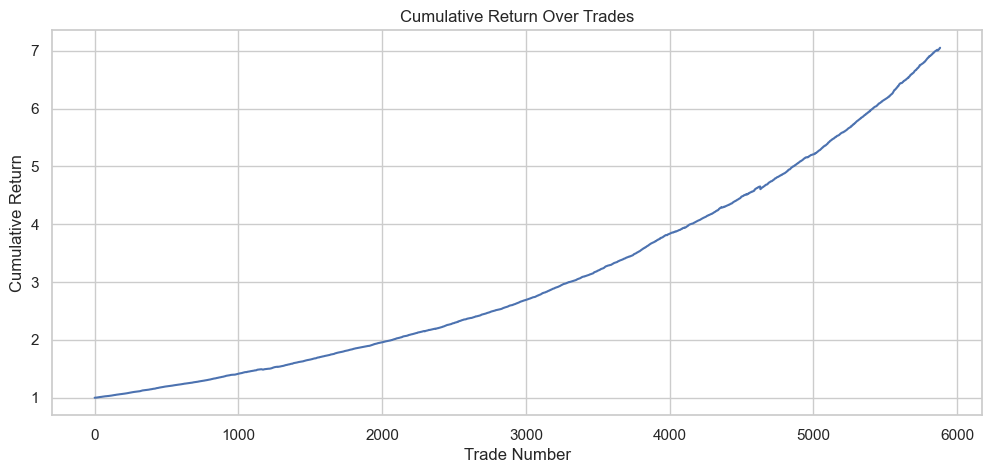

In [42]:
paired['cumulative_return'] = (1 + paired['return_pct'] / 100).cumprod()

plt.figure(figsize=(12, 5))
plt.plot(paired['cumulative_return'])
plt.title("Cumulative Return Over Trades")
plt.xlabel("Trade Number")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

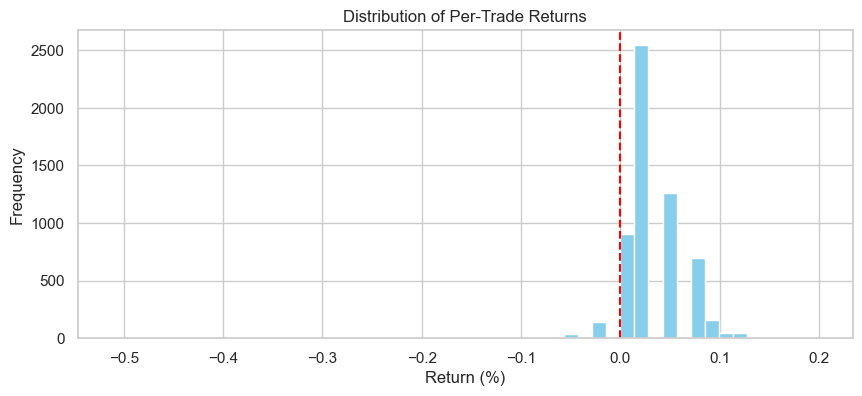

In [43]:
plt.figure(figsize=(10, 4))
plt.hist(paired['return_pct'], bins=50, color='skyblue')
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution of Per-Trade Returns")
plt.xlabel("Return (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [44]:
from numpy import sqrt

mean = paired['return_pct'].mean()
std = paired['return_pct'].std()
sharpe = (mean / std) * sqrt(252)  # approximate daily frequency

print("Estimated Sharpe Ratio: {:.2f}".format(sharpe))

Estimated Sharpe Ratio: 16.84


In [36]:
# ---------------------------------------
# 1. Compute Per-Trade Returns (Fixed)
# ---------------------------------------

# Ensure we're only using buy/sell entries
buy_sell_trades = trades_df[trades_df['trade_type'].isin(['BUY', 'SELL'])].copy()

# Add trade_id to group entries
buy_sell_trades['trade_id'] = (buy_sell_trades['trade_type'] == 'BUY').cumsum()

# Check distribution (optional debug)
print("Buy/Sell trade counts:\n", buy_sell_trades['trade_type'].value_counts())

# Pivot trades to get buy/sell pairs
long_trades = buy_sell_trades.pivot(index='trade_id', columns='trade_type', values=['timestamp', 'price', 'z_score'])

# Drop incomplete trades (e.g., only BUY without SELL)
long_trades = long_trades.dropna()

# Flatten multi-index columns safely
long_trades.columns = [f"{a}_{b}".lower() for a, b in long_trades.columns]
long_trades.reset_index(drop=True, inplace=True)

# Debug: check available columns
print("Available columns after pivot:", long_trades.columns.tolist())

# Compute return per trade
long_trades['return_pct'] = (long_trades['price_sell'] - long_trades['price_buy']) / long_trades['price_buy'] * 100
long_trades['hold_time'] = long_trades['timestamp_sell'] - long_trades['timestamp_buy']

# Display stats
print("\nSample round-trip trades:")
display(long_trades[['timestamp_buy', 'price_buy', 'timestamp_sell', 'price_sell', 'return_pct', 'hold_time']].head())

print("\nAverage return per trade: {:.3f}%".format(long_trades['return_pct'].mean()))
print("Average hold time: {:.1f} ticks".format(long_trades['hold_time'].mean()))
print("Win rate: {:.1f}%".format((long_trades['return_pct'] > 0).mean() * 100))

KeyError: 'trade_type'

KeyError: 'trade_type'

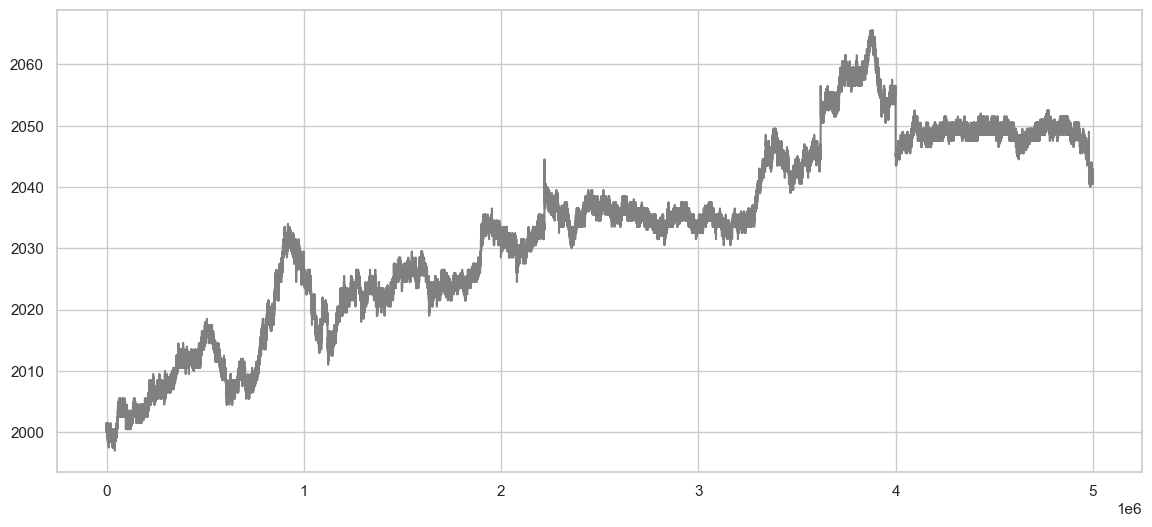

In [37]:
# ---------------------------------------
# 2. Plot Mid Price with Buy/Sell Markers
# ---------------------------------------

plt.figure(figsize=(14, 6))
plt.plot(kelp_data['timestamp'], kelp_data['mid_price'], label='Mid Price', color='gray')

# Plot buy markers
buy_points = trades_df[trades_df['trade_type'] == 'BUY']
plt.scatter(buy_points['timestamp'], buy_points['price'], color='green', label='Buy', marker='^', s=80)

# Plot sell markers
sell_points = trades_df[trades_df['trade_type'] == 'SELL']
plt.scatter(sell_points['timestamp'], sell_points['price'], color='red', label='Sell', marker='v', s=80)

plt.title("KELP Mid Price with Buy/Sell Signals")
plt.xlabel("Timestamp")
plt.ylabel("Mid Price")
plt.legend()
plt.grid(True)
plt.show()